In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os
import zipfile
from sklearn.utils import class_weight
from skimage.feature import local_binary_pattern


In [6]:
# Define paths for the zip file and its extraction location
zip_path = '/content/faces_224.zip'
unzip_path = '/content'
# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)
# Update the image path
image_path = unzip_path

In [2]:
def create_efficientnet_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False  # Freeze the base model initially

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [3]:
def create_data_augmentation():
    return ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],
        zoom_range=0.2,
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    )

In [4]:
def train_efficientnet_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, epochs=20):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_generator, validation_steps=validation_steps,
                        callbacks=callbacks)

    return history

In [16]:
def fine_tune_efficientnet_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, epochs=10):
    base_model = model.layers[0]
    base_model.trainable = True

    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),   #
                  loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_generator, validation_steps=validation_steps,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

    return history

In [17]:
# Feature extraction and generator function
def extract_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    return cv2.normalize(hist, hist).flatten()

def extract_edges(image):
    edges = cv2.Canny(image, 100, 200)
    edges_hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
    return cv2.normalize(edges_hist, edges_hist).flatten()

def extract_lbp(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    return hist / hist.sum()  # Normalize the histogram


In [18]:
def retrieve_generator(set_name, image_path, target_size=(224, 224), batch_size=64):
    while True:
        for start in range(0, len(set_name), batch_size):
            images, labels = [], []
            end = min(start + batch_size, len(set_name))
            batch_set = set_name[start:end]

            for img, imclass in zip(batch_set['videoname'], batch_set['label']):
                img_path = os.path.join(image_path, img[:-4] + '.jpg')
                image = cv2.imread(img_path)

                if image is not None:
                    image = cv2.resize(image, target_size)
                    images.append(image)
                    labels.append(1 if imclass == 'FAKE' else 0)

            # Yield batch with only images and labels
            yield np.array(images), np.array(labels)

Loading metadata...
Metadata loaded.
Splitting dataset...
Dataset split complete.
Creating model...
Training model...
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 82ms/step - accuracy: 0.5694 - loss: 3.6534 - val_accuracy: 0.6475 - val_loss: 1.7285 - learning_rate: 0.0010
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6250 - loss: 1.5227 - val_accuracy: 0.6631 - val_loss: 1.0019 - learning_rate: 0.0010
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6411 - loss: 0.9591 - val_accuracy: 0.6658 - val_loss: 0.8067 - learning_rate: 0.0010
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.6593 - loss: 0.7925 - val_accuracy: 0.6650 - val_loss: 0.7330 - learning_rate: 0.0010
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.6538 - loss: 0.7332 - val_accuracy: 0.6696 - val_loss: 0.6998 - learning_rate: 0.0010
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.6548 - loss: 0.7073 - val_accuracy: 0.6579 -

Final Test Accuracy: 0.7592


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

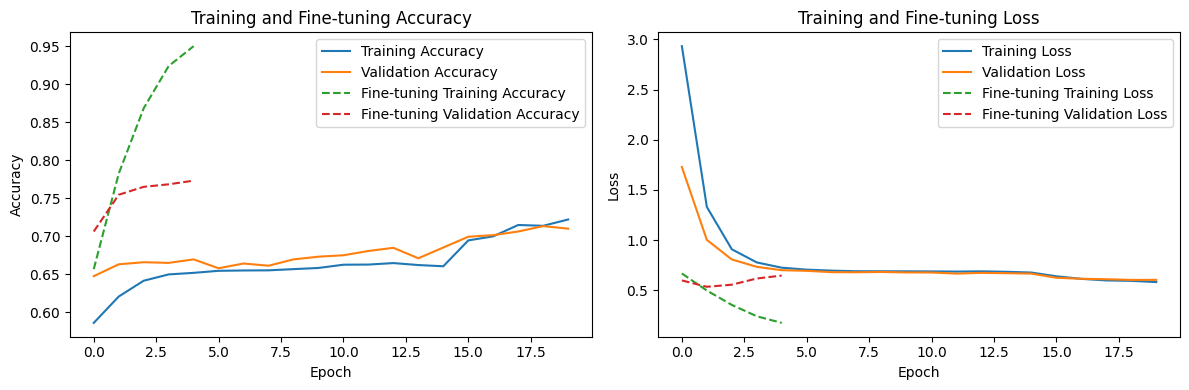

In [19]:
if __name__ == "__main__":
    metadata_path = r"/content/metadata.csv"
    image_path = r"/content/faces_224"

    print("Loading metadata...")
    df = pd.read_csv(metadata_path)
    print("Metadata loaded.")

    print("Splitting dataset...")
    real_df = df[df["label"] == "REAL"]
    fake_df = df[df["label"] == "FAKE"]
    sample_size = 10000
    real_df = real_df.sample(sample_size, random_state=42)
    fake_df = fake_df.sample(sample_size, random_state=42)
    sample_meta = pd.concat([real_df, fake_df])

    Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
    Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])
    print("Dataset split complete.")

    batch_size = 32
    train_generator = retrieve_generator(Train_set, image_path=image_path, batch_size=batch_size )
    val_generator = retrieve_generator(Val_set, image_path=image_path, batch_size=batch_size)
    test_generator = retrieve_generator(Test_set, image_path=image_path, batch_size=batch_size)

    steps_per_epoch = len(Train_set) // batch_size
    validation_steps = len(Val_set) // batch_size

    print("Creating model...")
    model = create_efficientnet_model()

    print("Training model...")
    history = train_efficientnet_model(model, train_generator, val_generator, steps_per_epoch, validation_steps)

    print("Fine-tuning model...")
    history_ft = fine_tune_efficientnet_model(model, train_generator, val_generator, steps_per_epoch, validation_steps)

    print("Evaluating model...")
    test_loss, test_accuracy = model.evaluate(test_generator, steps=len(Test_set) // batch_size)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    from google.colab import files
    model.save('deepfake_detector_efficientnetb0.h5')
    files.download('deepfake_detector_efficientnetb0.h5')

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history_ft.history['accuracy'], label='Fine-tuning Training Accuracy', linestyle='--')
    plt.plot(history_ft.history['val_accuracy'], label='Fine-tuning Validation Accuracy', linestyle='--')
    plt.title('Training and Fine-tuning Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history_ft.history['loss'], label='Fine-tuning Training Loss', linestyle='--')
    plt.plot(history_ft.history['val_loss'], label='Fine-tuning Validation Loss', linestyle='--')
    plt.title('Training and Fine-tuning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()